# Exploring the correlation between study time of subject and exam performance
## Introduction
The modeling of relative knowledge levels for students within different domains is essential for web-based adaptive learning services. Adaptive learning is a system where teaching is built around the student, adjusting itself based on the needs of students to provide an efficient learning experience. This is done through the use of AI, the AI uses different variables to decide the knowledge level of the student and helps them determine their most efficient learning schedule. This poses the question, **can we use the degree of study time of both the goal object and its prerequisites to predict whether a student will score an A on a goal object exam?** To answer this question, we will be utilizing the “User Knowledge Modeling” dataset created by Hamdi Tolga Kahraman et al. This dataset uses 5 variables, the degree of study time for goal object materials (STG), the degree of repetition number of user for goal object materials (SCG), the degree of study time of user for related objects with goal object (STR), the exam performance of user for related objects with goal object (LPR), the exam performance of user for goal objects (PEG) to calculate the knowledge level of the user (UNS).

## Methods
The K-nearest neighbor classification algorithm was used to predict whether a student will score an A on their goal subject exam. First, the numerical variable of exam performance for goal objects (PEG) was mutated into a categorical variable of letter grades (LG), which details whether the student scored an A or not based on the UBC Vancouver Academic Calendar for 2022/23. To clarify, a grade of A includes "A", "A-", and "A+". Next, the classification model was trained based on the variables of the degree of study time on the goal object (STG) and degree of study time on prerequisites (STR), and letter grades. For the classification model, we decided to use upsampling because the number of “Not A” data points far outweighs the number of “A” data points. We then used cross-validation with 5-folds along with parameter value selection to obtain a k-value of 21. From the line plot and metrics data, 21 was chosen as the number of neighbors since 1 and 6 would overfit the training data while 51 and 61 would be too computationally inefficient. Finally, we used the k-value of 21 along with our recipe and model to test our algorithm against the testing data set.

## Preliminary exploratory data analysis

In [2]:
# Install libraries shown
library(tidyverse)
library(repr)
library(rvest)
library(readxl)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘rvest’ was built under R version 4.0.2”
Loading required package: xml2


Attaching package: ‘rvest’


The following object is masked from ‘package:purrr’:

    pluck


The following object is masked from ‘package:readr’:

    guess_encoding


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
─

#### *Reading in file*

In [3]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
path <- "user_knowledge.xls"
download.file(url, destfile = path)

user_knowledge_training <- read_excel(path, range = "Training_Data!A1:F259") # training data
user_knowledge_testing <- read_excel(path, range = "Test_Data!A1:F146") # testing data

head(user_knowledge_training, 6)
head(user_knowledge_testing, 6)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


Remarks: The data is already tidy.

#### *Wrangling data*

In [4]:
user_knowledge_training$LG <- user_knowledge_training$PEG %>% # converts variable for exam performance on goal object (PEG) to letter grade (LG)
    cut(breaks = c(0,0.8,1),
       right = FALSE) %>% 
    recode("[0,0.8)" = "Not A",
          "[0.8,1)" = "A")

user_knowledge_testing$LG <- user_knowledge_testing$PEG %>% # converts variable for exam performance on goal object (PEG) to letter grade (LG)
    cut(breaks = c(0,0.8,1),
       right = FALSE) %>% 
    recode("[0,0.8)" = "Not A",
          "[0.8,1)" = "A")

user_knowledge_training <- select(user_knowledge_training, STG, STR, LG) # only keeping variables to be used
user_knowledge_testing <- select(user_knowledge_testing, STG, STR, LG)

user_knowledge_training

user_knowledge_testing

STG,STR,LG
<dbl>,<dbl>,<fct>
0.00,0.00,Not A
0.08,0.10,A
0.06,0.05,Not A
⋮,⋮,⋮
0.54,0.71,Not A
0.50,0.81,Not A
0.66,0.76,Not A


STG,STR,LG
<dbl>,<dbl>,<fct>
0.00,0.50,Not A
0.05,0.55,Not A
0.08,0.63,A
⋮,⋮,⋮
0.56,0.77,Not A
0.66,0.81,Not A
0.68,0.79,Not A


#### *Summary tables (based on training data)*

In [5]:
summary_table <- tibble("observations" = nrow(user_knowledge_training), "number of NA values" = sum(is.na(user_knowledge_training)))

var_desc <- tibble(variable = c("STG", "STR", "LG"),
                   description = c("The degree of study time for goal object materials (Electrical DC Machines)",
                                   "The degree of study time of user for prerequisites to goal object",
                                   "The letter grade corresponding to the exam performance of user for goal object"))

summary(user_knowledge_training)

var_desc

summary_table

      STG              STR             LG     
 Min.   :0.0000   Min.   :0.0000   Not A:227  
 1st Qu.:0.2407   1st Qu.:0.2913   A    : 31  
 Median :0.3270   Median :0.4900              
 Mean   :0.3711   Mean   :0.4680              
 3rd Qu.:0.4950   3rd Qu.:0.6900              
 Max.   :0.9900   Max.   :0.9500              

variable,description
<chr>,<chr>
STG,The degree of study time for goal object materials (Electrical DC Machines)
STR,The degree of study time of user for prerequisites to goal object
LG,The letter grade corresponding to the exam performance of user for goal object


observations,number of NA values
<int>,<int>
258,0


#### *Initial visualization of training data*

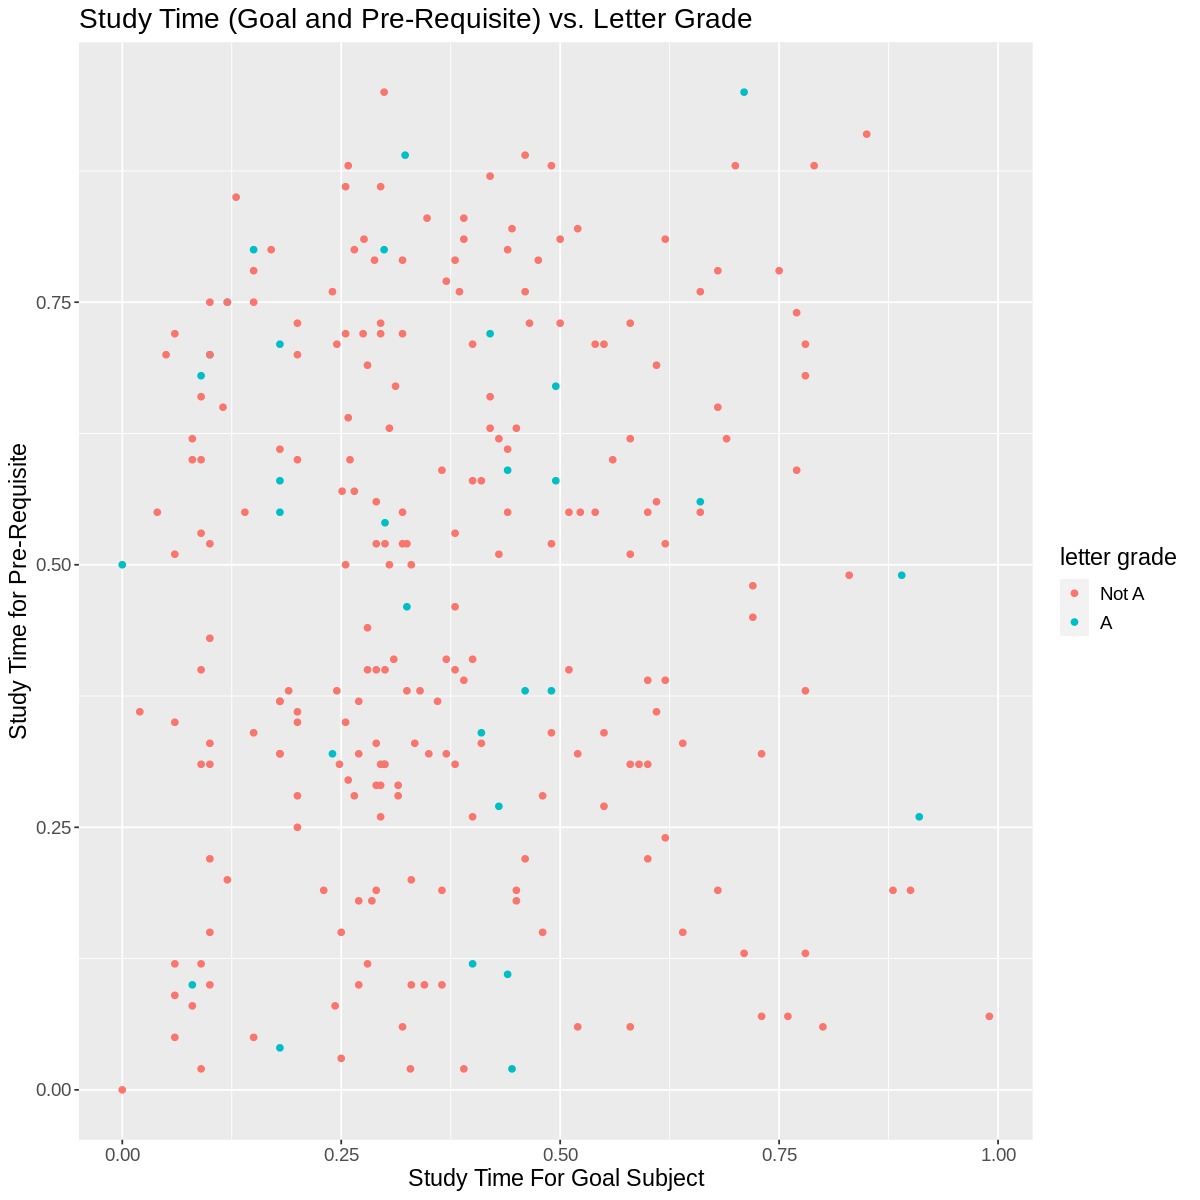

In [12]:
options(repr.plot.width = 10, repr.plot.height = 10)
user_knowledge_plot_goal <- ggplot(user_knowledge_training, aes(x = STG, y = STR)) +
    geom_point(aes(color = LG)) +
    labs(x = "Study Time For Goal Subject", y = "Study Time for Pre-Requisite", colour = "letter grade") +
    ggtitle("Study Time (Goal and Pre-Requisite) vs. Letter Grade") +
    theme(text = element_text(size = 14))

user_knowledge_plot_goal

This scatter diagram shows the goal study time in x-axis and prerequisite study time in y-axis. The grade for each single record was distinguished by the color that had a description on the right side. 


## Data Analysis

64% data in training set, 36% in testing data. 

STG,STR,LG
<dbl>,<dbl>,<fct>
0.00,0.00,Not A
0.08,0.10,A
0.06,0.05,Not A
⋮,⋮,⋮
0.54,0.71,Not A
0.50,0.81,Not A
0.66,0.76,Not A


Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


STG,STR,LG
<dbl>,<dbl>,<fct>
-1.765089,-1.902921,Not A
-1.384627,-1.496317,A
-1.479743,-1.699619,Not A
⋮,⋮,⋮
0.8030235,0.983965,Not A
0.6127930,1.390569,Not A
1.3737150,1.187267,Not A


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8063733,5,0.03340388,Model01
6,accuracy,binary,0.6827428,5,0.06816569,Model02
51,accuracy,binary,0.5663664,5,0.04928518,Model11
61,accuracy,binary,0.5436552,5,0.04413035,Model13
21,accuracy,binary,0.5430490,5,0.04589874,Model05
36,accuracy,binary,0.5354321,5,0.04520598,Model08


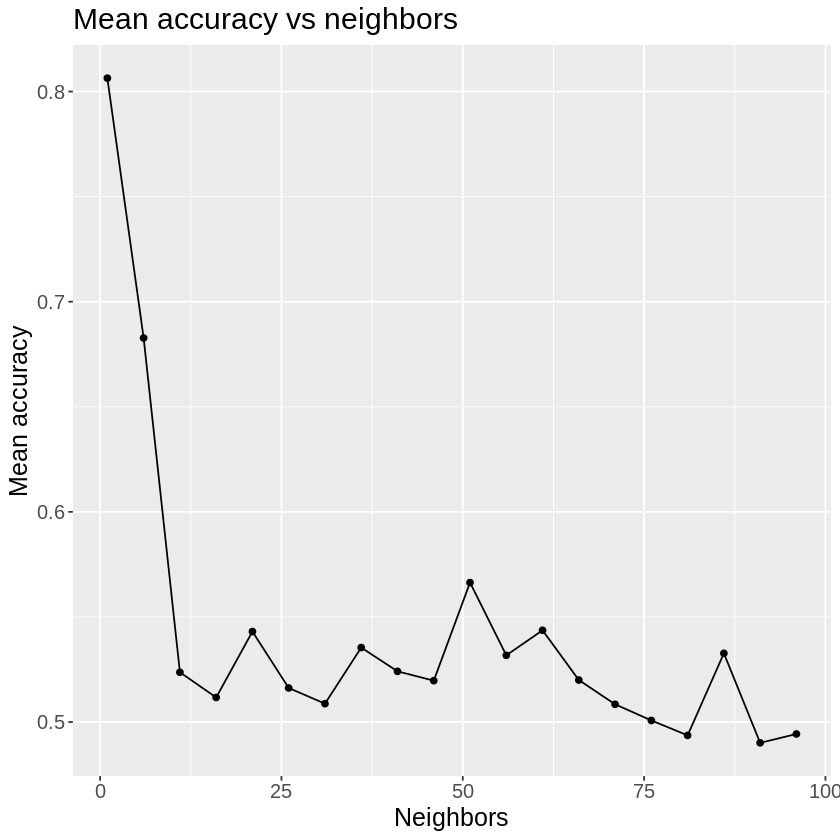

In [7]:
set.seed(2022)

user_knowledge_training

lg_recipe <- recipe(LG ~ STG + STR, data = user_knowledge_training) %>% # scales/centers training data, upsamples since there are very few "A" compared to "Not A"
    step_scale(all_predictors()) %>% 
    step_center(all_predictors()) %>% 
    step_upsample(LG, over_ratio = 1, skip = TRUE)

lg_upsample <- lg_recipe %>% 
    prep() %>% 
    bake(user_knowledge_training)
lg_upsample

lg_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

# lg_vfold <- vfold_cv(user_knowledge_training, v = 5, strata = LG) # 5-fold cross-validation
lg_vfold <- vfold_cv(lg_upsample, v = 5, strata = LG)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

lg_results <- workflow() %>% 
    add_recipe(lg_recipe) %>% 
    add_model(lg_spec) %>% 
    tune_grid(resamples = lg_vfold, grid = k_vals) %>% 
    collect_metrics() %>% 
    filter(.metric == "accuracy") %>% 
    group_by(neighbors) %>% 
    arrange(desc(mean))
head(lg_results)

lg_results_plot <- lg_results %>% 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Mean accuracy") +
    ggtitle("Mean accuracy vs neighbors") +
    theme(text = element_text(size = 15))
lg_results_plot

In [8]:
k <- 21 # From the line plot and metrics data above, 21 was chosen as the number of neighbors since 1 and 6 would overfit the 
        # training data while 51 and 61 would be too computationally inefficient.

lg_pred_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

lg_fit <- workflow() %>% 
    add_recipe(lg_recipe) %>% 
    add_model(lg_pred_spec) %>%
    fit(data = user_knowledge_training)

lg_pred <- predict(lg_fit, user_knowledge_testing) %>% 
    bind_cols(user_knowledge_testing)
lg_pred_metrics <- lg_pred %>% 
    metrics(truth = LG, estimate = .pred_class)
lg_pred_conf_mat <- lg_pred %>% 
    conf_mat(truth = LG, estimate = .pred_class)
lg_pred
lg_pred_metrics
lg_pred_conf_mat

.pred_class,STG,STR,LG
<fct>,<dbl>,<dbl>,<fct>
Not A,0.00,0.50,Not A
Not A,0.05,0.55,Not A
A,0.08,0.63,A
⋮,⋮,⋮,⋮
Not A,0.56,0.77,Not A
Not A,0.66,0.81,Not A
Not A,0.68,0.79,Not A


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.48965517
kap,binary,-0.09222313


          Truth
Prediction Not A  A
     Not A    60 21
     A        53 11

#### *Visualization of results*

.pred_class
<fct>
A
A
A
⋮
Not A
Not A
Not A


Grade,STG,STR
<fct>,<dbl>,<dbl>
A,0.000000000,0.01
A,0.009090909,0.01
A,0.018181818,0.01
⋮,⋮,⋮
Not A,0.8818182,0.91
Not A,0.8909091,0.91
Not A,0.9000000,0.91


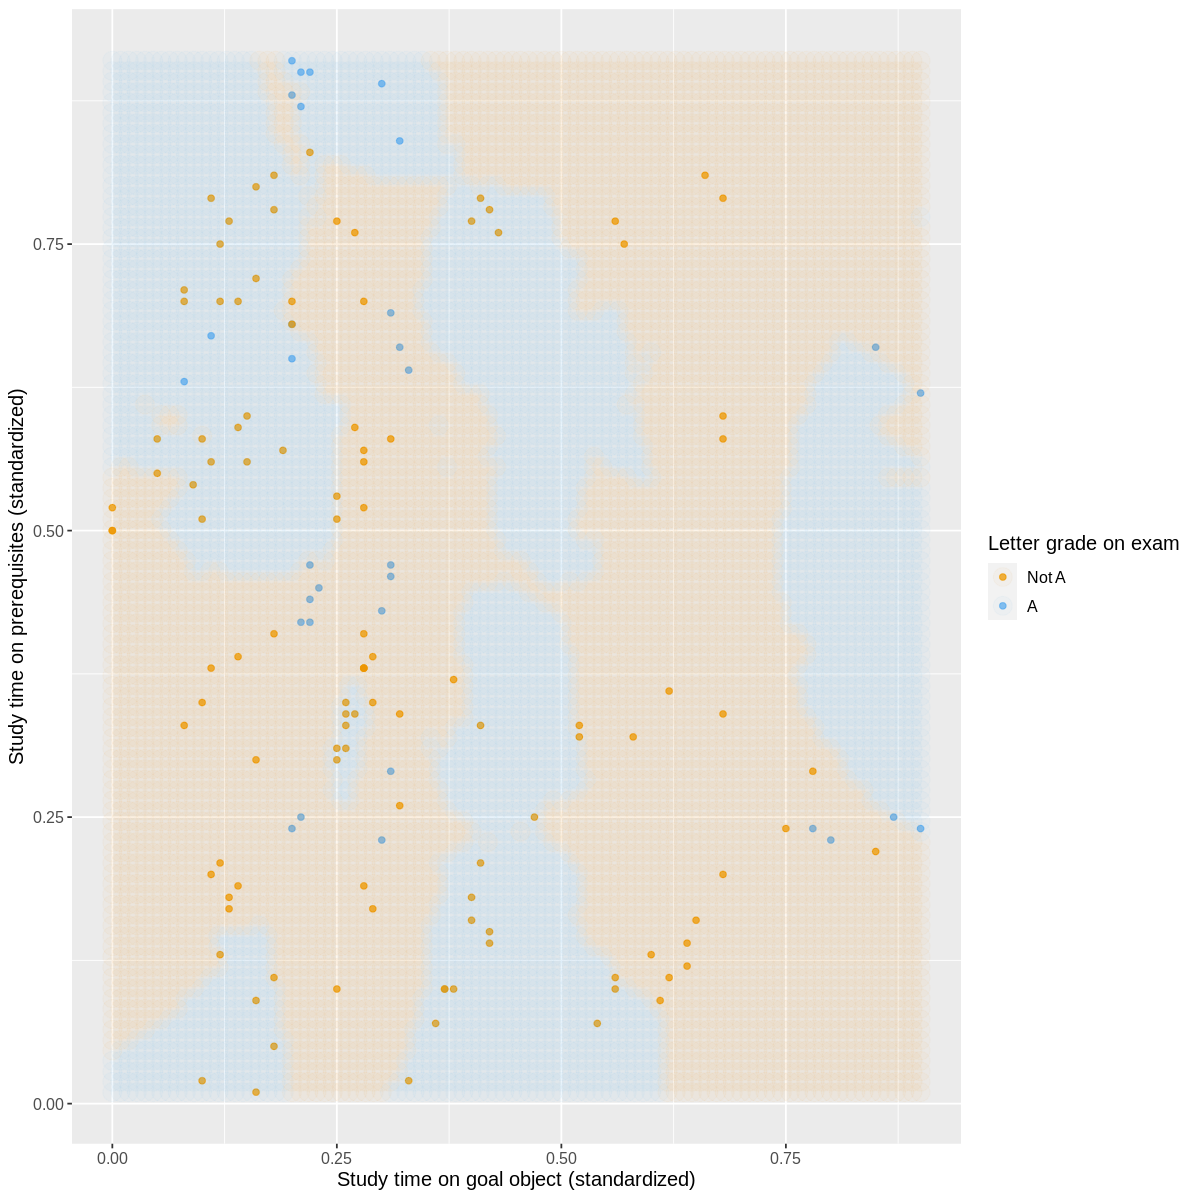

In [11]:
# creates a grid of STG and STR values, arranges into dataframe
stg_grid <- seq(min(user_knowledge_testing$STG),
               max(user_knowledge_testing$STG),
               length.out = 100)
str_grid <- seq(min(user_knowledge_testing$STR),
               max(user_knowledge_testing$STR),
               length.out = 100)
st_grid <- as_tibble(expand.grid(STG = stg_grid,
                                STR = str_grid))

# makes predictions on the grid values using the lg_fit workflow
knn_pred_grid <- predict(lg_fit, st_grid)
knn_pred_grid

# adds the predictions to the grid values dataframe
lg_pred_table <- bind_cols(knn_pred_grid, st_grid) %>% 
    rename(Grade = .pred_class)
lg_pred_table

# visualization plot: contains coloured scatter of original data and faded colour scatter of above grid points
options(repr.plot.width = 10, repr.plot.height = 10)
result_plot <- ggplot() +
    geom_point(data = user_knowledge_testing,
              mapping = aes(x = STG,
                           y = STR,
                           color = LG),
              alpha = 0.75) +
    geom_point(data = lg_pred_table,
              mapping = aes(x = STG,
                           y = STR,
                           color = Grade),
              alpha = 0.03,
              size = 5) +
    labs(x = "Study time on goal object (standardized)",
        y = "Study time on prerequisites (standardized)",
        color = "Letter grade on exam") +
    scale_color_manual(labels = c("Not A", "A"), 
                     values = c("orange2", "steelblue2")) +
    theme(text = element_text(size = 12))
result_plot

## Discussion


After analyzing our data, we have found that it is not viable to use the study time of target and prerequisite subjects to predict whether a student scored an A on their target subject examination. The accuracy of our classifier, which was around 49%, was significantly lower than expected and arguably disproves our initial predictions on the viability of using study time for both prerequisite subjects and target subjects to predict whether a student would score an A on their target subject. However, while our testing accuracy was drastically different from what we initially expected, the testing accuracy remains consistent with our cross-validation accuracy, therefore it is unlikely that there were any errors in our methodology or coding. Furthermore, there are some reasonable explanations for why the accuracy of our classifier was so low. Firstly, after reviewing the methodology in which the data was collected, we found that the study time for both the prerequisite and target subjects was self-reported by the students. This means that there is likely a significant amount of information bias linked to how students reported their study times and there is also a possibility that students were untruthful in their self-reporting. Secondly, after reviewing the accuracy of our classifier, there is the possibility of other lurking variables, such as whether a student had a tutor or the quality and concentration of their study sessions, that could also influence a student’s grading. Therefore, it is reasonable to conclude that study time for target and prerequisite subjects alone does not determine if a student receives a high score on their target subject tests.
However, since our classifier’s accuracy is similar to that of a coin toss, we are unable to formulate a solid conclusion on the influence of study time on grade scoring. This ultimately leaves the door open for future analysis, such as testing whether other variables, such as exam performance for related subjects, would be good predictors for whether a student would achieve an A on their target exam. 

## Bibliography
Moskal, Patsy Carter, et al. “7 Things You Should Know about Adaptive Learning.” 7 Things You Should Know About Adaptive Learning, 4 Jan. 2017, https://library.educause.edu/resources/2017/1/7-things-you-should-know-about-adaptive-learning. 

“The University of British Columbia.” Introduction - Grading Practices - Campus-Wide Policies and Regulations - Vancouver Academic Calendar 2022/23 - UBC Student Services, https://www.calendar.ubc.ca/vancouver/index.cfm?tree=3%2C42%2C96%2C0. 

Kahraman, Hamdi Tolga, et al. “User Knowledge Modeling Data Set.” UCI Machine Learning Repository: User Knowledge Modeling Data Set, 26 June 2013, https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling#. 